 <hr style="border-width:4px; border-style:solid; border-color:green"/>

# Modelling Temporal Coefficients

<hr style="border-width:4px; border-style:solid; border-color:green"/>


In [1]:
from packages import *
import EOFsfunction 
import Soil_moisture_weights
from IPython.display import Image

## Dataset

The SPMIP data was generated with the aim of asessing the influence of parameters on the variability of Land Surface models. The CLM5 model was run using the same soil properties throughout the soil columns from 1980 - 2010. The documentaion how the data was generated can be found on [SPMIP documentation](https://www.gewexevents.org/wp-content/uploads/GLASS2017_SP-MIP_Protocol.pdfhttps://www.gewexevents.org/wp-content/uploads/GLASS2017_SP-MIP_Protocol.pdf)  

- Experiment 1: Soil-hydraulic parameters provided by SP-MIP 
- Experiment 2: Soil-hyraulic parameters derived from common soil textural properties 
- Experiment 3: Reference run with all models in their status quo

- Experiment 4: Spatial uniform soil parameters

 Experiment 4 was run using different soil deigns corresponding to loamy sand (Experiment 4a), loam (experiment 4b), clay (experiment 4c), and silt (experiment 4d).

### Loading the Soil Parameter Model Intercomparison Project (SP-MIP) Data

In [2]:
path = "/scratch/ksilwimba/Data/US_data/"

data_EX1 = xr.open_dataset(path + "/CLM5_experiment_1_US_1980-2010.nc")
data_EX2 = xr.open_dataset(path + "/CLM5_experiment_2_US_1980-2010.nc")
data_EX3 = xr.open_dataset(path + "/CLM5_experiment_3_US_1980-2010.nc")
data_EX4a = xr.open_dataset(path + "/CLM5_experiment_4a_US_1980-2010.nc")
data_EX4b = xr.open_dataset(path + "/CLM5_experiment_4b_US_1980-2010.nc")
data_EX4c = xr.open_dataset(path + "/CLM5_experiment_4c_US_1980-2010.nc")
data_EX4d = xr.open_dataset(path + "/CLM5_experiment_4d_US_1980-2010.nc")

<div class="alert alert-success">

### Weighted Soil Average from each SP-NIP experiment

Computing the soil moisture weights for each experiment (1,2,3,4a,4b,4d) using the soil moisture weights function `soil_weighted_ave`.

In [3]:
#============================Average weighted soil moisture for each experiment soil moisture SPMIP data
exp1_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX1)
exp2_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX2)
exp3_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX3)
exp4a_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX4a)
exp4b_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX4b)
exp4c_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX4c)
exp4d_soilm_weighted_ave = Soil_moisture_weights.soil_weighted_ave(data_EX4d)

print("Exp1 Weighted average soil moisture:",exp1_soilm_weighted_ave)
print("Exp2 Weighted average soil moisture:",exp2_soilm_weighted_ave)
print("Exp3 Weighted average soil moisture:",exp3_soilm_weighted_ave)
print("Exp4a Weighted average soil moisture:",exp4a_soilm_weighted_ave)
print("Exp4b Weighted average soil moisture:",exp4b_soilm_weighted_ave)
print("Exp4c Weighted average soil moisture:",exp4c_soilm_weighted_ave)
print("Exp4d Weighted average soil moisture:",exp4d_soilm_weighted_ave)

Exp1 Weighted average soil moisture: 0.3745540304978689
Exp2 Weighted average soil moisture: 0.3938839022318522
Exp3 Weighted average soil moisture: 0.3874005428949992
Exp4a Weighted average soil moisture: 0.2688321538766225
Exp4b Weighted average soil moisture: 0.34623083035151164
Exp4c Weighted average soil moisture: 0.4346072538693746
Exp4d Weighted average soil moisture: 0.5025383722782135


<div class="alert alert-success">



# Empirical Orthogonal Function Analysis 



The function computes the follwing:
- Correlation map EOFS 
- Empirical orthogonal functions (EOFS)
- Principal component time series (PCs)
- Eigenvalues (decreasing variance) associated with each EOF
- Fraction EOF mode variance: The fraction of the total variance explained by each EOF mode, values between 0 and 1 inclusive.The fraction of the total variance explained by each EOF mode, values between 0 and 1 inclusive.
- Total variance associated with the field of anomalies (the sum of the eigenvalues)Total variance associated with the field of anomalies (the sum of the eigenvalues)

In [4]:
def Emp_Ortho_Funcs(CLM5_data, n_eof,lat):
    "The function computes the empirical orthogonal functions and the corresponding time series"

    if len(CLM5_data.shape) == 4:
        nt,nlat,nlon,ndepth = CLM5_data.shape
    elif len(CLM5_data.shape) == 3:
        nt,nlat,nlon = CLM5_data.shape
           
    print("...Detrending The Data by removing the time-mean...")
    CLM5_detrend = signal.detrend(CLM5_data,axis=0, type='constant',bp=0)
    CLM5_data_season = np.mean(CLM5_detrend,axis=0)
    CLM5_detrend = CLM5_detrend - CLM5_data_season
        
    if len(CLM5_data.shape) == 4:
        CLM5_detrend = CLM5_detrend.reshape((nt,nlat,nlon,ndepth), order='F')
    elif len(CLM5_data.shape) == 3:
        CLM5_detrend = CLM5_detrend.reshape((nt,nlat,nlon), order='F') 
       
    print("....Latitude Weighting...")
    coslat = np.cos(np.deg2rad(lat[:]))
    #wgts   = coslat.reshape(len(coslat), 1)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    if len(CLM5_detrend.shape) == 4:           
        solver = Eof(CLM5_detrend[:,:,:,:], weights=wgts)
    elif len(CLM5_detrend.shape) == 3:
        solver = Eof(CLM5_detrend[:,:,:], weights=wgts)
            
    print("....Computing EOFs..." )    
    eofs = solver.eofs(neofs=n_eof,eofscaling=1)
    pcs  = solver.pcs(npcs=n_eof, pcscaling=1).round(5)
    var_fracs = solver.varianceFraction()
    lambdas = solver.eigenvalues()
    eofs_corr = solver.eofsAsCorrelation(neofs=n_eof)  
    eofs_cov = solver.eofsAsCovariance(neofs=n_eof)
    total_variance = solver.totalAnomalyVariance()
    
    return wgts, eofs, pcs, var_fracs, lambdas, eofs_corr

### Extracting SP-MIP Variables Experiment 1,2,3,4a,4b,4c,4d

Extracting the soil moisture variable `mrsl`, then slicing the root zone depth ($\approx$ 0 - 200 cm) defined in the [CLM5 Docmuntation](https://www.cesm.ucar.edu/models/cesm2/land/CLM50_Tech_Note.pdf). 

In [5]:
n_eof = 4
#-------------------------Water content Per Unit Area of Soil layers (soil Moisture)
"Computing the mean of the soil moisture at each soil layer "
exp1_mrlsl = data_EX1.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')*exp1_soilm_weighted_ave
exp2_mrlsl = data_EX2.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')*exp2_soilm_weighted_ave
exp3_mrlsl = data_EX3.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')*exp3_soilm_weighted_ave
exp4a_mrlsl = data_EX4a.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')*exp4a_soilm_weighted_ave
exp4b_mrlsl = data_EX4b.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')*exp4b_soilm_weighted_ave
exp4c_mrlsl = data_EX4c.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')*exp4c_soilm_weighted_ave
exp4d_mrlsl = data_EX4d.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')*exp4d_soilm_weighted_ave

#-------------------------Soil temperature
"Compputing the mean soil temperature at each soil depth"
sExp1_tsl = data_EX1['tsl'].sel(levgrnd=slice(0,2)).mean('levgrnd')
sExp2_tsl = data_EX2['tsl'].sel(levgrnd=slice(0,2)).mean('levgrnd')
sExp3_tsl = data_EX3['tsl'].sel(levgrnd=slice(0,2)).mean('levgrnd')
sExp4a_tsl = data_EX4a['tsl'].sel(levgrnd=slice(0,2)).mean('levgrnd')
sExp4b_tsl = data_EX4b['tsl'].sel(levgrnd=slice(0,2)).mean('levgrnd')
sExp4c_tsl = data_EX4c['tsl'].sel(levgrnd=slice(0,2)).mean('levgrnd')
sExp4d_tsl = data_EX4d['tsl'].sel(levgrnd=slice(0,2)).mean('levgrnd')

#-------------------------Total Evapotranspiration 
sExp1_et = data_EX1['et']
sExp2_et = data_EX2['et']
sExp3_et = data_EX3['et']
sExp4a_et = data_EX4a['et']
sExp4b_et = data_EX4b['et']
sExp4c_et = data_EX4c['et']
sExp4d_et = data_EX4d['et']

#-------------------------Surface snow melt flux
snm_Exp1 = data_EX1['snm']
snm_Exp2 = data_EX2['snm']
snm_Exp3 = data_EX3['snm']
snm_Exp4a = data_EX4a['snm']
snm_Exp4b = data_EX4b['snm']
snm_Exp4c = data_EX4c['snm']
snm_Exp4d = data_EX4d['snm']

In [6]:
print("New shape", exp1_mrlsl.shape, "old shape", data_EX1.mrlsl.shape)
print("New shape", sExp1_tsl.shape, "old shape", data_EX1.tsl.shape)
print("New shape", sExp1_et.shape, "old shape", data_EX1.et.shape)
print("New shape", snm_Exp1.shape, "old shape", data_EX1.snm.shape)

New shape (11315, 60, 140) old shape (11315, 20, 60, 140)
New shape (11315, 60, 140) old shape (11315, 25, 60, 140)
New shape (11315, 60, 140) old shape (11315, 60, 140)
New shape (11315, 60, 140) old shape (11315, 60, 140)


### Applying the  Empirical orthogal function on the SP-MIP data

In [7]:
#--------------------------Experiment 1
lat = data_EX1.lat.data
mrlslwgts1, mrlsleofs1, mrlslpcs1, mrlslvar_fracs1, mrlsllambdas1, mrlsleofs_corr1 = Emp_Ortho_Funcs(exp1_mrlsl, n_eof,lat)
tslwgts1, tsleofs1, tslpcs1, tslvar_fracs1, tsllambdas1, tsleofs_corr1 = Emp_Ortho_Funcs(sExp1_tsl, n_eof,lat)
etwgts1, eteofs1, etpcs1, etvar_fracs1, etlambdas1, eteofs_corr1 = Emp_Ortho_Funcs(sExp1_et, n_eof,lat)
snmwgts1, snmeofs1, snmpcs1, snmvar_fracs1, snmlambdas1, snmeofs_corr1 = Emp_Ortho_Funcs(snm_Exp1, n_eof,lat)

#--------------------------Experiment 2
mrlslwgts2, mrlsleofs2, mrlslpcs2, mrlslvar_fracs2, mrlsllambdas2, mrlsleofs_corr2 = Emp_Ortho_Funcs(exp2_mrlsl, n_eof,lat)
tslwgts2, tsleofs2, tslpcs2, tslvar_fracs2, tsllambdas2, tsleofs_corr2 = Emp_Ortho_Funcs(sExp2_tsl, n_eof,lat)
etwgts2, eteofs2, etpcs2, etvar_fracs2, etlambdas2, eteofs_corr2 = Emp_Ortho_Funcs(sExp2_et, n_eof,lat)
snmwgts2, snmeofs2, snmpcs2, snmvar_fracs2, snmlambdas2, snmeofs_corr2 = Emp_Ortho_Funcs(snm_Exp2, n_eof,lat)

#--------------------------Experiment 3
mrlslwgts3, mrlsleofs3, mrlslpcs3, mrlslvar_fracs3, mrlsllambdas3, mrlsleofs_corr3 = Emp_Ortho_Funcs(exp3_mrlsl, n_eof,lat)
tslwgts3, tsleofs3, tslpcs3, tslvar_fracs3, tsllambdas3, tsleofs_corr3 = Emp_Ortho_Funcs(sExp3_tsl, n_eof,lat)
etwgts3, eteofs3, etpcs3, etvar_fracs3, etlambdas3, eteofs_corr3 = Emp_Ortho_Funcs(sExp3_et, n_eof,lat)
snmwgts3, snmeofs3, snmpcs3, snmvar_fracs3, snmlambdas3, snmeofs_corr3 = Emp_Ortho_Funcs(snm_Exp3, n_eof,lat)

#--------------------------Experiment 4a
mrlslwgts4a, mrlsleofs4a, mrlslpcs4a, mrlslvar_fracs4a, mrlsllambdas4a, mrlsleofs_corr4a = Emp_Ortho_Funcs(exp4a_mrlsl, n_eof,lat)
tslwgts4a, tsleofs4a, tslpcs4a, tslvar_fracs4a, tsllambdas4a, tsleofs_corr4a = Emp_Ortho_Funcs(sExp4a_tsl, n_eof,lat)
etwgts4a, eteofs4a, etpcs4a, etvar_fracs4a, etlambdas4a, eteofs_corr4a = Emp_Ortho_Funcs(sExp4a_et, n_eof,lat)
snmwgts4a, snmeofs4a, snmpcs4a, snmvar_fracs4a, snmlambdas4a, snmeofs_corr4a = Emp_Ortho_Funcs(snm_Exp4a, n_eof,lat)

#--------------------------Experiment 4b
mrlslwgts4b, mrlsleofs4b, mrlslpcs4b, mrlslvar_fracs4b, mrlsllambdas4b, mrlsleofs_corr4b = Emp_Ortho_Funcs(exp4b_mrlsl, n_eof,lat)
tslwgts4b, tsleofs4b, tslpcs4b, tslvar_fracs4b, tsllambdas4b, tsleofs_corr4b = Emp_Ortho_Funcs(sExp4b_tsl, n_eof,lat)
etwgts4b, eteofs4b, etpcs4b, etvar_fracs4b, etlambdas4b, eteofs_corr4b = Emp_Ortho_Funcs(sExp4b_et, n_eof,lat)
snmwgts4b, snmeofs4b, snmpcs4b, snmvar_fracs4b, snmlambdas4b, snmeofs_corr4b = Emp_Ortho_Funcs(snm_Exp4b, n_eof,lat)

#--------------------------Experiment 4c
mrlslwgts4c, mrlsleofs4c, mrlslpcs4c, mrlslvar_fracs4c, mrlsllambdas4c, mrlsleofs_corr4c = Emp_Ortho_Funcs(exp4c_mrlsl, n_eof,lat)
tslwgts4c, tsleofs4c, tslpcs4c, tslvar_fracs4c, tsllambdas4c, tsleofs_corr4c = Emp_Ortho_Funcs(sExp4c_tsl, n_eof,lat)
etwgts4c, eteofs4c, etpcs4c, etvar_fracs4c, etlambdas4c, eteofs_corr4c = Emp_Ortho_Funcs(sExp4c_et, n_eof,lat)
snmwgts4c, snmeofs4c, snmpcs4c, snmvar_fracs4c, snmlambdas4c, snmeofs_corr4c = Emp_Ortho_Funcs(snm_Exp4c, n_eof,lat)

#--------------------------Experiment 4d
mrlslwgts4d, mrlsleofs4d, mrlslpcs4d, mrlslvar_fracs4d, mrlsllambdas4d, mrlsleofs_corr4d = Emp_Ortho_Funcs(exp4d_mrlsl, n_eof,lat)
tslwgts4d, tsleofs4d, tslpcs4d, tslvar_fracs4d, tsllambdas4d, tsleofs_corr4d = Emp_Ortho_Funcs(sExp4d_tsl, n_eof,lat)
etwgts4d, eteofs4d, etpcs4d, etvar_fracs4d, etlambdas4d, eteofs_corr4d = Emp_Ortho_Funcs(sExp4d_et, n_eof,lat)
snmwgts4d, snmeofs4d, snmpcs4d, snmvar_fracs4d, snmlambdas4d, snmeofs_corr4d = Emp_Ortho_Funcs(snm_Exp4d, n_eof,lat)

...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...
...Detrending The Data by removing the time-mean...
....Latitude Weighting...
....Computing EOFs...


In [8]:
print(mrlsllambdas1.shape)
print(mrlsleofs1.shape)
print(mrlsleofs_corr1.shape)
print(mrlslpcs1.shape) 

(4503,)
(4, 60, 140)
(4, 60, 140)
(11315, 4)


<div class="alert alert-success">

### Target Variable 

We consider Water content per Unit Area of Soil as our target variable for the machine learning algorithms to implemented.

##### Reference Soil Moisture

In [9]:
soil_moisture = data_EX3.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')*exp1_soilm_weighted_ave
soil_moisture = soil_moisture.mean(dim=['lat', 'lon']).to_dataframe().reset_index()
scaler1=MinMaxScaler()
#========================Transforming the data
y=scaler1.fit_transform(np.array(soil_moisture["mrlsl"]).reshape(-1,1))

##### Reconstructed Soil Moisture

In [11]:
#========================Computing the reconstructed soil moisture
exp3_mrlsl = data_EX1.mrlsl.sel(levsoi=slice(0,10)).mean('levsoi')
n_eof = 4
eofs3, pcs3, var_fracs3, lambdas3, eofs_corr3, eof_corrpcs3,reconstruction3 \
                                                                     =EOFsfunction.Emp_Ortho_Funcs(exp3_mrlsl, n_eof)

...Detrending the Data by removing the time-mean...
....Checking Setting Weighting...
....Decomposing Modes of SPMIP Data...
...Correlating.....


In [12]:
Exp3mrlsl_SMreconstructed = xr.DataArray(reconstruction3,
                           coords=exp3_mrlsl.coords, dims=exp3_mrlsl.dims, attrs=data_EX1.attrs)
Exp3mrlsl_SMreconstructedT = Exp3mrlsl_SMreconstructed.mean(dim=("lat","lon"))
#========================Transforming the data
y_reconstructed = scaler1.fit_transform(np.array(Exp3mrlsl_SMreconstructedT).reshape(-1,1))

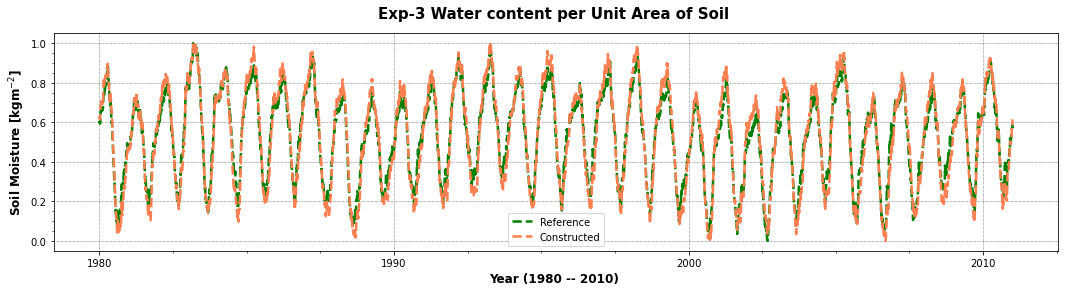

In [13]:
#========================Plotting the Constructed and the reference data 
plt.figure(figsize = (18,4))
plt.plot(soil_moisture["time"],y, linewidth=2.5,label="Reference",
         linestyle='dashed',c="green")
plt.plot(Exp3mrlsl_SMreconstructedT.time, y_reconstructed, linewidth=2.5,label="Constructed",
         linestyle='dashed', c="coral")
plt.minorticks_on()
plt.ylabel("Soil Moisture [kgm$^{-2}$]",fontweight='bold',  fontsize=12)
plt.title(f"Exp-3 Water content per Unit Area of Soil ", pad=15,fontweight='bold', fontsize=15)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("Year (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.legend(loc="best")
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

<div class="alert alert-success">

### Visualizing the Selected Input Variables 

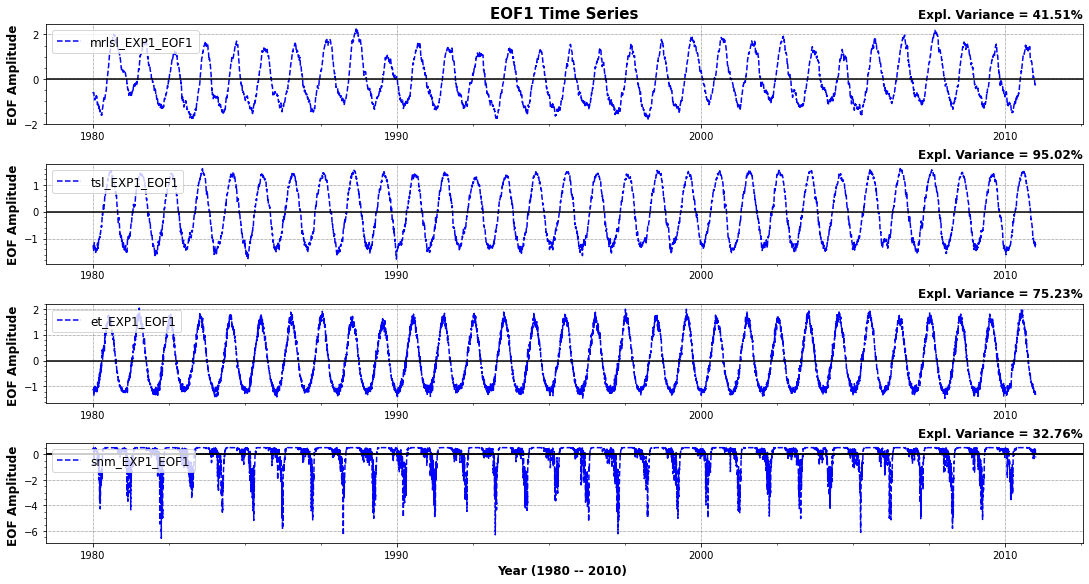

In [15]:
#=======================================================================
# EOF 2 Time Series
#=======================================================================
plt.figure(figsize = (18,9))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

#=========================== Soil moisture 
plt.subplot(4,1,1)
plt.plot(soil_moisture["time"], mrlslpcs1[:,0], label="mrlsl_EXP1_EOF1",
         linewidth=1.5,linestyle='dashed',c="blue")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.title("EOF1 Time Series",fontweight='bold',fontsize=15)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(mrlslvar_fracs1[0]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Soil temperature
plt.subplot(4,1,2)
plt.plot(soil_moisture["time"], tslpcs1[:,0], linewidth=1.5,label="tsl_EXP1_EOF1",
         linestyle='dashed',c="blue")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(tslvar_fracs1[0]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Total evapotranspiration
plt.subplot(4,1,3)
plt.plot(soil_moisture["time"], etpcs1[:,0], linewidth=1.5,label="et_EXP1_EOF1",
         linestyle='dashed',c="blue")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude ",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(etvar_fracs1[0]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Surface snow melt
plt.subplot(4,1,4)
plt.plot(soil_moisture["time"], snmpcs1[:,0], linewidth=1.5,label="snm_EXP1_EOF1",
         linestyle='dashed',c="blue")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude ",fontweight='bold',  fontsize=12)
plt.title(f"Expl. Variance = {(snmvar_fracs1[0]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.xlabel("Year (1980 -- 2010) ",fontweight='bold',fontsize=12)

plt.show()

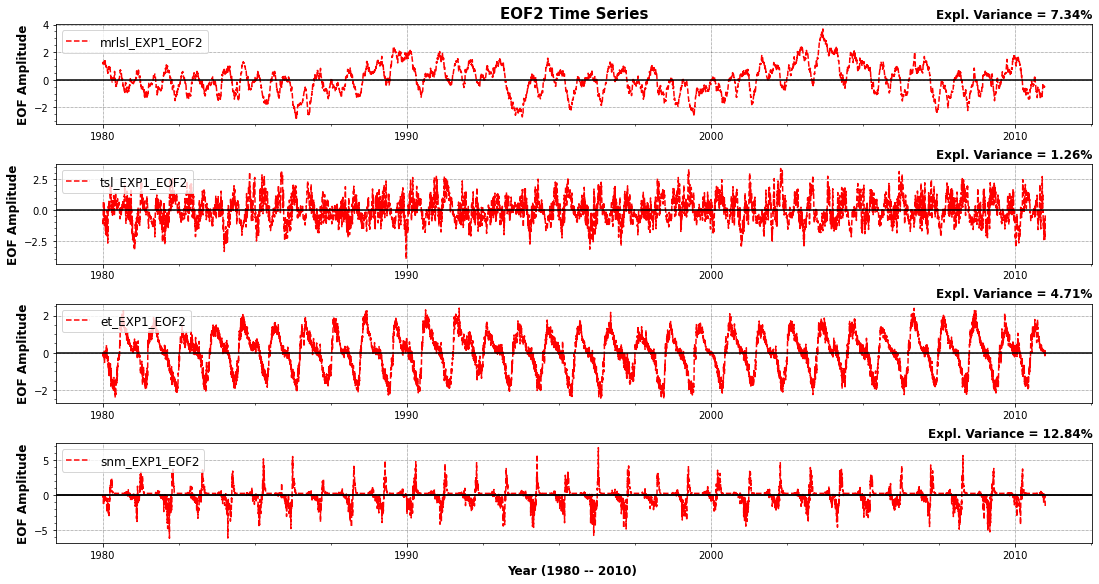

In [16]:
#=======================================================================
# EOF 2 Time Series
#=======================================================================

plt.figure(figsize = (18,9))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

#=========================== Soil moisture 
plt.subplot(4,1,1)
plt.plot(soil_moisture["time"], mrlslpcs1[:,1], \
         label="mrlsl_EXP1_EOF2",linewidth=1.5,linestyle='dashed',c="red")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.title("EOF2 Time Series",fontweight='bold',fontsize=15)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(mrlslvar_fracs1[1]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Soil temperature
plt.subplot(4,1,2)
plt.plot(soil_moisture["time"], tslpcs1[:,1], \
         linewidth=1.5,label="tsl_EXP1_EOF2",linestyle='dashed',c="red")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(tslvar_fracs1[1]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Total evapotranspiration
plt.subplot(4,1,3)
plt.plot(soil_moisture["time"] ,etpcs1[:,1],\
         linewidth=1.5,label="et_EXP1_EOF2",linestyle='dashed',c="red")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(etvar_fracs1[1]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Surface snow melt
plt.subplot(4,1,4)
plt.plot(soil_moisture["time"], snmpcs1[:,1], \
         linewidth=1.5,label="snm_EXP1_EOF2",linestyle='dashed',c="red")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.title(f"Expl. Variance = {(snmvar_fracs1[1]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.xlabel("Year (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.show()

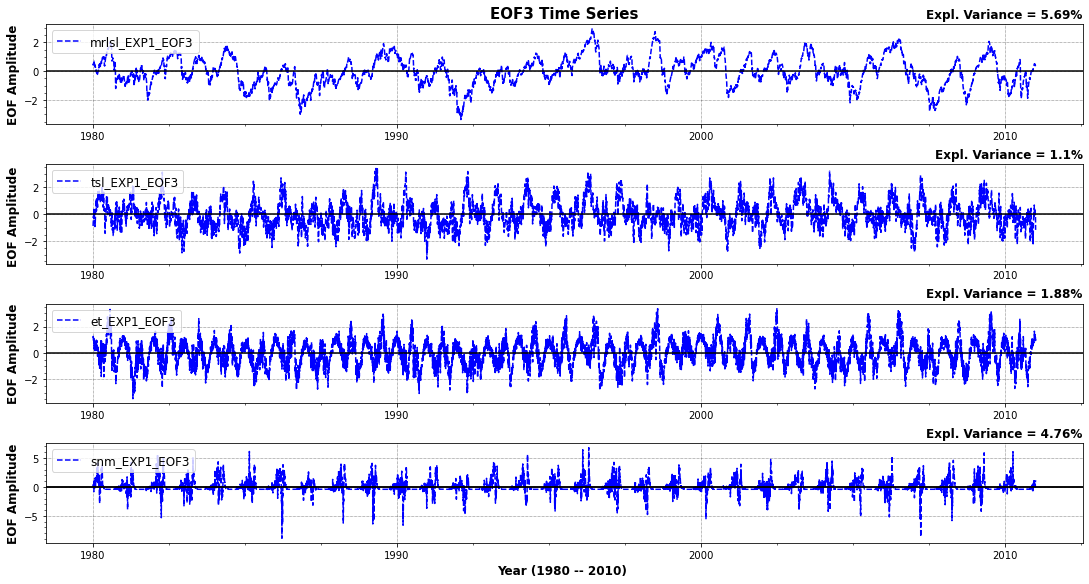

In [17]:
#=======================================================================
# EOF 3 Time Series
#=======================================================================
plt.figure(figsize = (18,9))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

#=========================== Soil moisture
plt.subplot(4,1,1)
plt.plot(soil_moisture["time"], mrlslpcs1[:,2], \
         label="mrlsl_EXP1_EOF3",linewidth=1.5,linestyle='dashed',c="blue")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.title("EOF3 Time Series",fontweight='bold',fontsize=15)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(mrlslvar_fracs1[2]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Soil temperature
plt.subplot(4,1,2)
plt.plot(soil_moisture["time"], tslpcs1[:,2], \
         linewidth=1.5,label="tsl_EXP1_EOF3",linestyle='dashed',c="blue")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude ",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(tslvar_fracs1[2]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Total evapotranspiration
plt.subplot(4,1,3)
plt.plot(soil_moisture["time"], etpcs1[:,2], \
         linewidth=1.5,label="et_EXP1_EOF3",linestyle='dashed',c="blue")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.title(f"Expl. Variance = {(etvar_fracs1[2]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)

#=========================== Surface snow melt
plt.subplot(4,1,4)
plt.plot(soil_moisture["time"], snmpcs1[:,2], \
         linewidth=1.5,label="snm_EXP1_EOF3",linestyle='dashed',c="blue")
plt.minorticks_on()
plt.axhline(0, color='k')
plt.legend(loc="upper left", fontsize=12)
plt.ylabel("EOF Amplitude",fontweight='bold',  fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.title(f"Expl. Variance = {(snmvar_fracs1[2]*100).round(2)}%", \
          loc='right',fontweight='bold',size=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axhline(0, color='k')
plt.xlabel("Year (1980 -- 2010) ",fontweight='bold',fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

<div class="alert alert-success">

### Splitting the data 

In [19]:
#========================Time splits
time_split = [3650, 7865] #[4015, 7300]
timesplit=time_split[1]
#========================Concatinating and Splitting the Input data
x = np.concatenate((tslpcs1, etpcs1, snmpcs1),axis=1)
train_x,test_x = x[:timesplit,:],x[timesplit:,:]

In [20]:
#========================Spliting the Reference and Reconstructed
train_y,test_y = y[:timesplit,:],y[timesplit:,:]
train_reconstructedY,test_reconstructedY = y_reconstructed[:timesplit,:], y_reconstructed[timesplit:,:]

<div class="alert alert-success">

## Neural Networks 

Artificial neural networks are computational systems that, often without any task-specific rules encoded into them, may learn to do tasks by taking into account instances. It is meant to resemble a biological system in which neurons communicate with one another by delivering mathematical functions as signals between layers. A weight variable represents each connection between neurons in a layer, and any number of neurons may be present in a layer.Artificial neural networks are computational systems that, often without any task-specific rules encoded into them, may learn to do tasks by taking into account instances. It is meant to resemble a biological system in which neurons communicate with one another by delivering mathematical functions as signals between layers. A weight variable represents each connection between neurons in a layer, and any number of neurons may be present in a layer.

**Choice of Model Architecture**

The model architecture will be a neural network. We chosed to bring about a linear relationship between soil temperature, snow melt, soil moiture, evapontanspiration, as scientificlly we have been taught that as the temperatures at the earth's surface increases then more evaporation occurs, and hence more precipitation occurs. If more precipitation occurs then the soil moiture will increase. All these inferences convinced us that all the three parameters (soil temperature, snow melt, soil moiture, evapontanspiration) are somewhat linearly related and hence We choose to select Neural network to predict one parameter on the basis of the other parameters. The model architecture in the figure below was implemented.


**Implementations**

To create the input and the output dataset for training, we merged the three parameters (i.e soil temperature and evapontanspiration, snow melt dataset) to form the input vector for our model.

- Callbacks these are functions called during the training loop. They allow to better monitor the model.
- Activation function are functions used in a neural network to compute the weighted sum of inputs and biases and then activate a neuron.



Currently implemented:
1. `Early stop`:  stop training if the validation loss does not improve for 100 consecutive epochs.
2. `Checkpoint`:  save the best neural net after each epoch.
3. `relu`: actiavtion function is used. ReLU is a nonlinear or piecewise linear function that, if the input is positive, outputs the input directly; if not, it outputs zero.


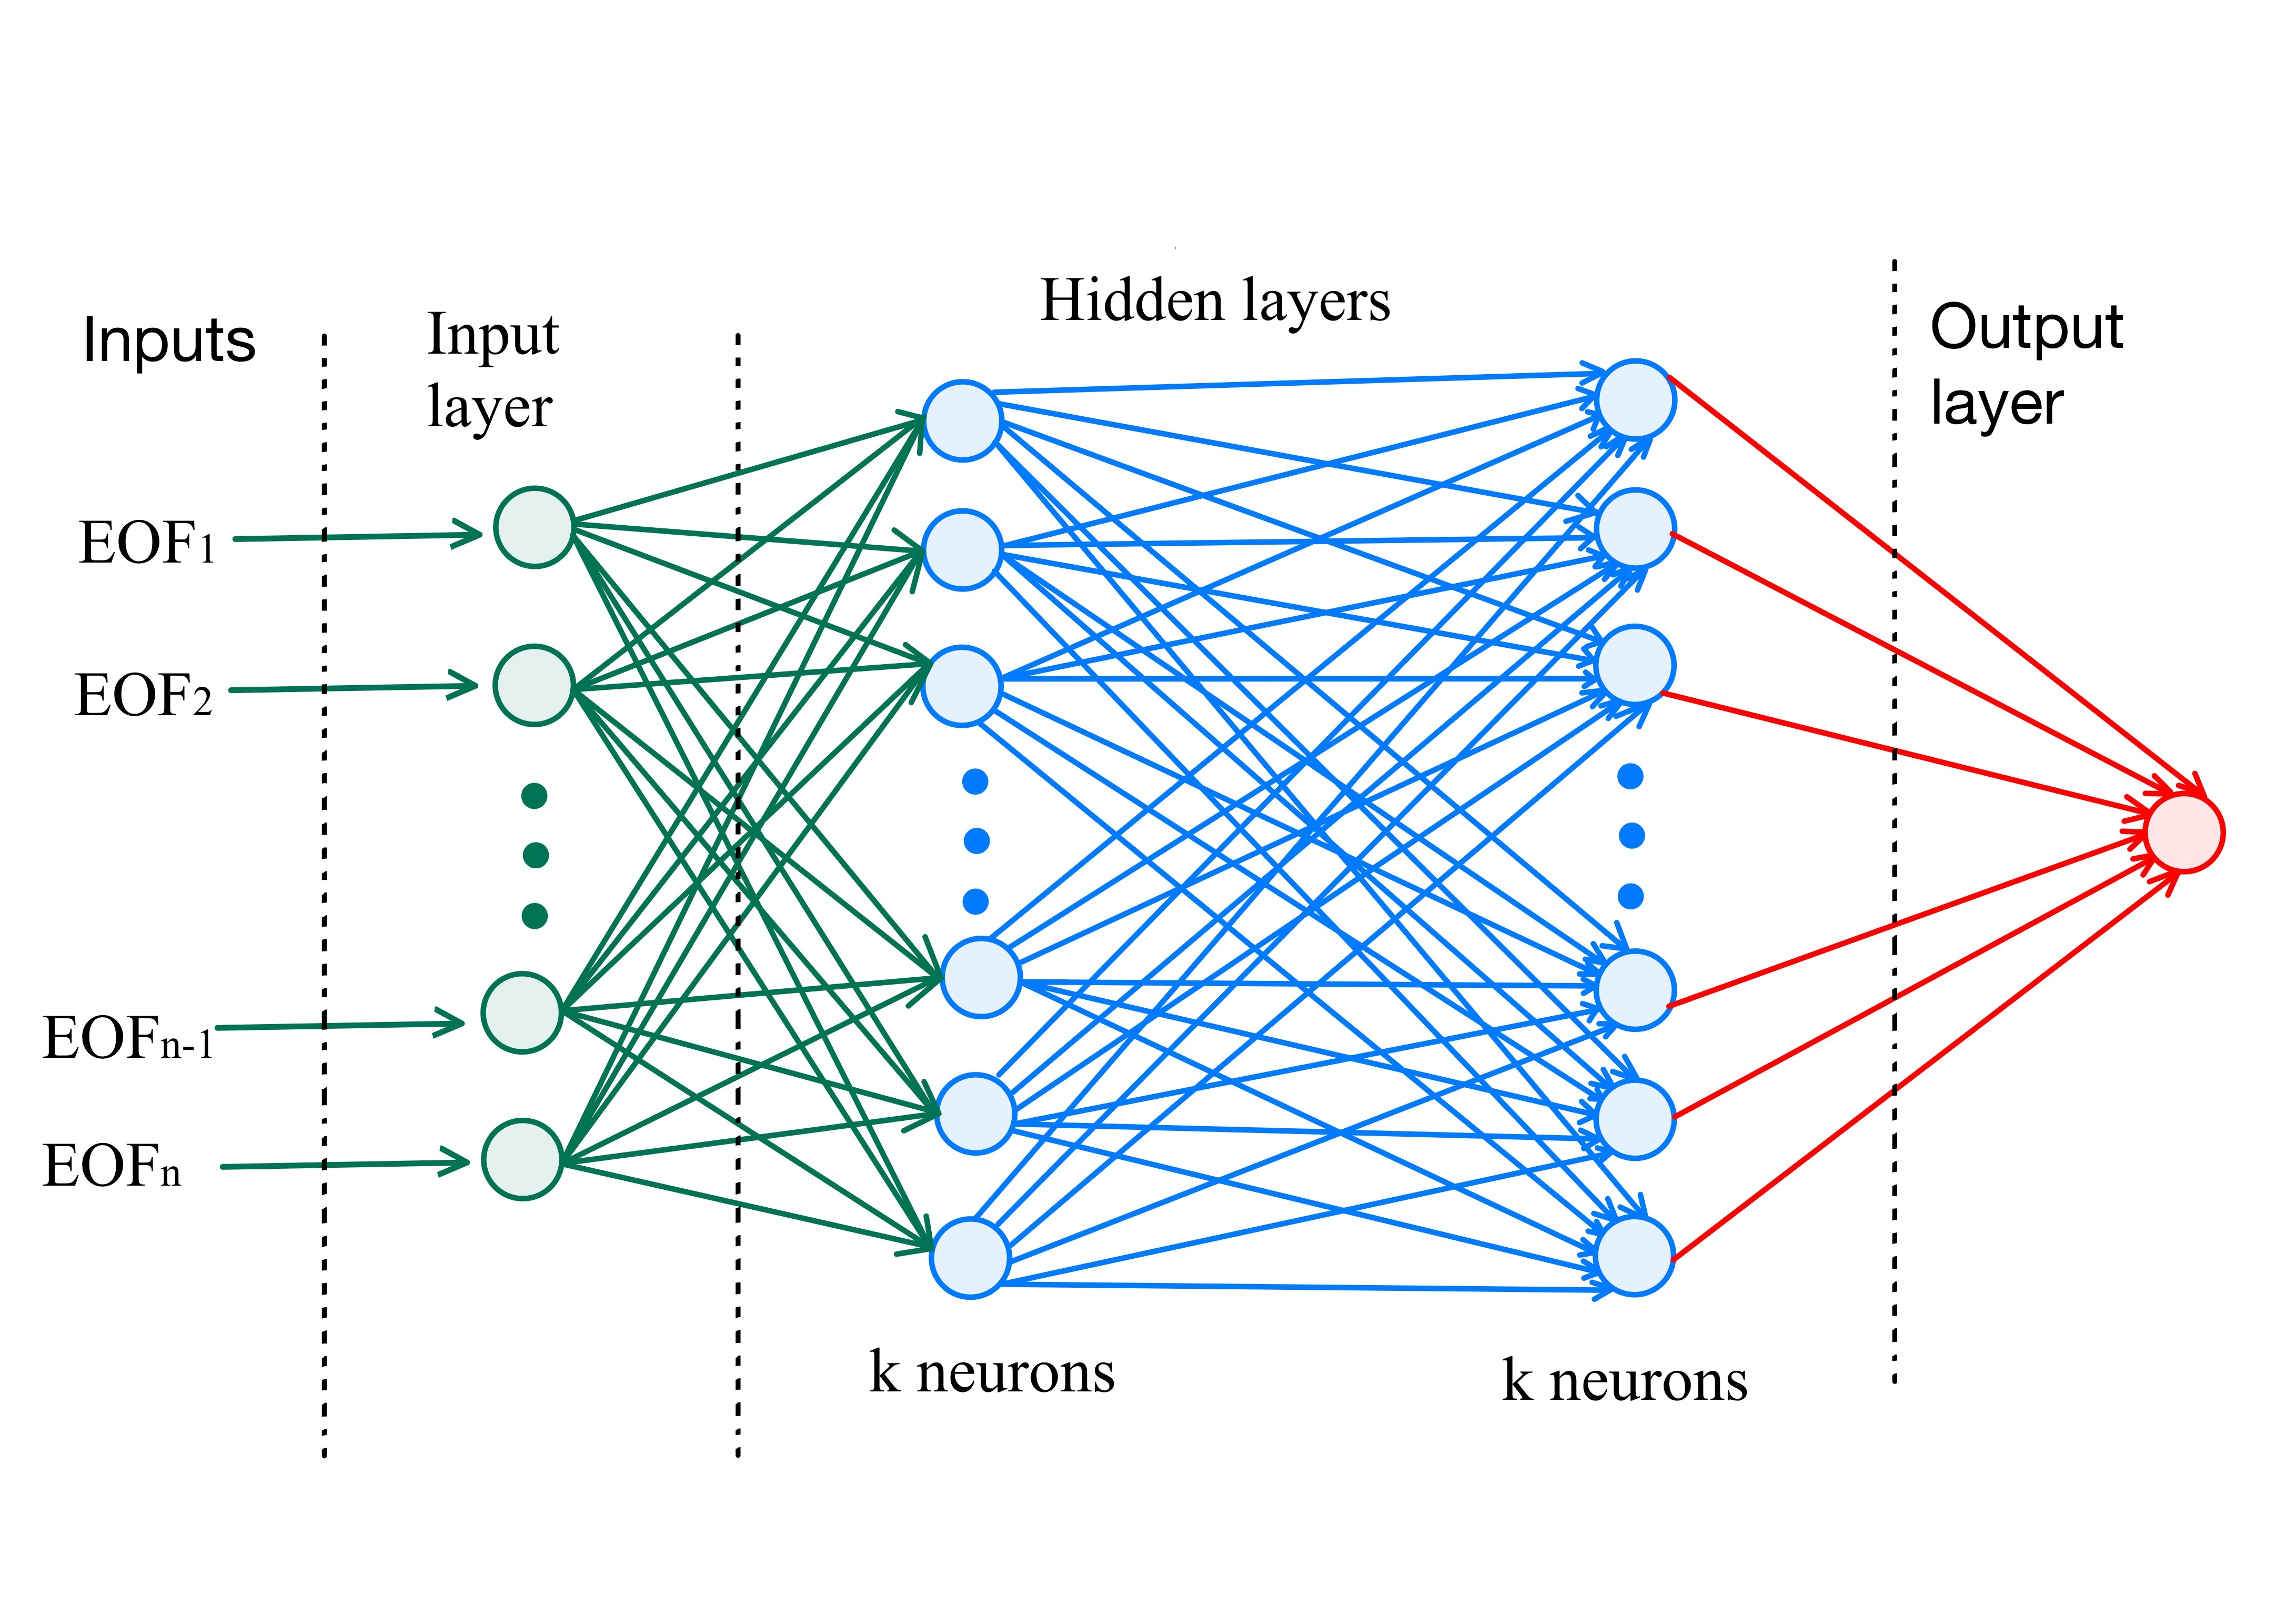

In [22]:
Image(filename='Kachinga-2.JPG',width=600, height=350)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 20)                260       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 492
Trainable params: 492
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-11-02 23:49:00.548035: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


160/168 [===========================>..] - ETA: 0s - loss: 0.1653 - accuracy: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.00029, saving model to /home/ksilwimba/NN_SM.ckpt
168/168 [==============================] - 1s 3ms/step - loss: 0.1606 - accuracy: 0.0000e+00 - val_loss: 0.0529 - val_accuracy: 2.8986e-04 - lr: 0.0010
Epoch 2/100
162/168 [===========================>..] - ETA: 0s - loss: 0.0433 - accuracy: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.00029
168/168 [==============================] - 0s 1ms/step - loss: 0.0429 - accuracy: 0.0000e+00 - val_loss: 0.0285 - val_accuracy: 2.8986e-04 - lr: 0.0010
Epoch 3/100
160/168 [===========================>..] - ETA: 0s - loss: 0.0276 - accuracy: 0.0000e+00
Epoch 3: val_accuracy did not improve from 0.00029
168/168 [==============================] - 0s 1ms/step - loss: 0.0273 - accuracy: 0.0000e+00 - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
158/168 [===========================>..] - 

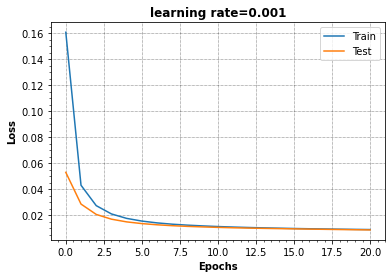

Model Training Completed


In [23]:
#===========================================================================
# Building Neural Networks                                                  
#===========================================================================
def build_nn_model(n_features, n_outputs, hidden_nodes, emb_size, optimizer='adam', lr=1e-3,loss="mse",
                    activation='relu', reg=None):
    """
    Arguments:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer
    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]

    features_in = tf.keras.layers.Input(shape=(n_features,))
    x = features_in
    for h in hidden_nodes:
        x = tf.keras.layers.Dense(h, activation=activation, kernel_regularizer=reg)(x)
    x = tf.keras.layers.Dense(n_outputs, activation='linear', kernel_regularizer=reg)(x)
    model = tf.keras.models.Model(inputs=[features_in], outputs=x)
    return model

#===========================================================================
# Neural Networks with Reference Y Input
#===========================================================================

in_shape = 12
batch_size = 47
model_save = "/home/ksilwimba/NN_SM.ckpt"
model_nn = build_nn_model(in_shape,2,[20,10],10,loss="mse")
modsave = tf.keras.callbacks.ModelCheckpoint(model_save, monitor='val_accuracy', verbose=1, save_best_only=True,save_weights_only=True,
                                             mode='auto',include_optimizer=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.092,patience=20, min_lr=0.001,verbose=1)
er_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0, patience=20, verbose=1, mode='auto',baseline=None, 
                                           restore_best_weights=False)
opt = tf.optimizers.Adam(learning_rate=1e-3) 
model_nn.compile(optimizer=opt, loss="mse",metrics=['accuracy'])
model_nn.summary()
callbacks=[modsave,reduce_lr,er_stop]
#=======================Reference Data
history_nn = model_nn.fit(train_x,train_y,batch_size=batch_size,epochs=100,shuffle=False,\
        callbacks=callbacks,validation_data=(test_x,test_y))

#=======================Reconstructed Data
Recon_history_nn = model_nn.fit(train_x,train_reconstructedY,batch_size=batch_size,epochs=100,shuffle=False,\
        callbacks=callbacks,validation_data=(test_x,test_reconstructedY))

#========================Predicting soil Moisture 
nnTrain_soilmoisture = model_nn.predict(train_x)
nnpredict_soilmoisture = model_nn.predict(test_x)

#========================Scaling the True Soil moisture
true_y  = scaler1.fit_transform(np.array(soil_moisture["mrlsl"]).reshape(-1,1)[timesplit:])
trueY_soilmoisture = scaler1.fit_transform(np.array(soil_moisture["mrlsl"]).reshape(-1,1)[timesplit:])
#========================Plot learning curve
plt.plot(history_nn.history['loss'],label='Train')
plt.plot(history_nn.history['val_loss'],label='Test')
plt.xlabel("Epochs",fontweight='bold', fontsize=10)
plt.ylabel("Loss" ,fontweight='bold', fontsize=10)
plt.title('learning rate='+str(1e-3), fontweight='bold', fontsize=12)#learning_rates[4]
plt.minorticks_on()
plt.legend()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()
print('Model Training Completed')
#print('Finish Time:%d s' %(int(time.time()-start)))

<div class="alert alert-success">

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_6 (Dense)             (None, 20)                260       
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 2)                 22        
                                                                 
Total params: 492
Trainable params: 492
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
152/168 [==========================>...] - ETA: 0s - loss: 0.2378 - accuracy: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /home/ksilwimba/NN_SMR.c

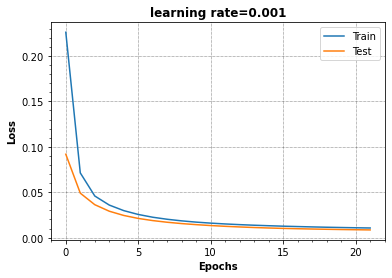

Model Training Completed


In [25]:
#===========================================================================
# Neural Networks with Reconstructed Y Input
#===========================================================================
in_shape2 = 12
batch_size2 = 47
model_save2 = "/home/ksilwimba/NN_SMR.ckpt"
model_nn2 = build_nn_model(in_shape2,2,[20,10],10,loss="mse")
modsave2 = tf.keras.callbacks.ModelCheckpoint(model_save2, monitor='val_accuracy', verbose=1, save_best_only=True,save_weights_only=True,
                                             mode='auto',include_optimizer=False)
reduce_lr2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.092,patience=15, min_lr=0.001,verbose=1)
er_stop2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.000, patience=20, verbose=1, mode='auto',baseline=None, 
                                           restore_best_weights=False)
opt2 = tf.optimizers.Adam(learning_rate=1e-3) 
model_nn2.compile(optimizer=opt2, loss="mse",metrics=['accuracy'])
model_nn2.summary()
callbacks=[modsave2,reduce_lr2,er_stop2]

#=======================Reconstructed Data
Recon_history_nn = model_nn2.fit(train_x,train_reconstructedY,batch_size=batch_size2,epochs=30,shuffle=False,\
        callbacks=callbacks,validation_data=(test_x,test_reconstructedY))#validation_split=0.1

#========================Predicting soil Moisture 
nnTrain_soilmoistureR = model_nn2.predict(train_x)
nnTest_soilmoistureR = model_nn2.predict(test_x)

reconstructed_Y = y_reconstructed.reshape(-1,1)[timesplit:]
#========================Plot learning curve
plt.plot(Recon_history_nn.history['loss'],label='Train',markeredgewidth=2.2)
plt.plot(Recon_history_nn.history['val_loss'],label='Test')
plt.xlabel("Epochs",fontweight='bold', fontsize=10)
plt.ylabel("Loss" ,fontweight='bold', fontsize=10)
plt.title('learning rate='+str(1e-3), fontweight='bold', fontsize=12)#learning_rates[4]
plt.minorticks_on()
plt.legend()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()
print('Model Training Completed')
#print('Finish Time:%d s' %(int(time.time()-start)))


<div class="alert alert-success">

## Gradient Boosting Regressor Model
This estimator allows for the optimization of any differentiable loss function and constructs an additive model in a forward stage-wise manner. A regression tree is fitted on the negative gradient of the provided loss function at each level. This estimator allows for the optimization of any differentiable loss function and constructs an additive model in a forward stage-wise manner. A regression tree is fitted on the negative gradient of the provided loss function at each level.

In [26]:
#===========================================================================
# gradient Boosting regressor Model
#===========================================================================


#===================== Learning rate 
learning_rate = 0.05
alpha = 0.6

#===================== GBRT model 
#{loss='quantile', learning_rate=learning_rate, verbose=1, alpha=alpha, n_estimators=300, max_depth=5}
def build_GBR_model(train_x,train_y,learning_rate,alpha):

        """
         Parameter:
            n_estimators: the number of boosting stages that will be performed
            max_depth: limits the number of nodes in the tree
            hidden_nodes: int or list of hidden nodes
            min_samples_split: the minimum number of samples required to split an internal node
            learning_rate: how much the contribution of each tree will shrink
            max_depth: limits the number of nodes in the tree
            min_samples_split : the minimum number of samples required to split an internal node
            learning_rate : how much the contribution of each tree will shrink.
            loss : loss function to optimize.n_estimators : the number of boosting stages that will be performed.
         Returns:
            model: Fitted Gradient Boosting Regressor
         """

        params = {"n_estimators": 300,
                           "max_depth": 5,
                           "min_samples_split": 5,
                           "learning_rate": learning_rate,"verbose":1,}
        model_gbr = GradientBoostingRegressor(loss ="quantile",alpha=alpha, **params)

        #===================== Fit regression model 
        model_gbr.fit(train_x,train_y)
        print('====Model Training Completed===')
        mse = mean_squared_error(train_y, model_gbr.predict(train_x))
        print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
        return model_gbr

model_gbr = build_GBR_model(train_x,train_y,learning_rate,alpha)

#===================== Predict 
gbr_Y = np.array(model_gbr.predict(x)).reshape(-1,1)
predict_gbr_Y_test = model_gbr.predict(test_x) #np.array(Modelgbr.predict(test_x)).reshape(-1,1)
gbr_predict_y = gbr_Y[timesplit:]
true_y = scaler1.fit_transform(np.array(soil_moisture["mrlsl"]).reshape(-1,1)[timesplit:])

# #====================== Plot training deviance
# test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
# for i, y_pred in enumerate(model_gbr.staged_predict(test_x)):
#     test_score[i] = model_gbr.loss_(test_y, y_pred)

        
# fig = plt.figure(figsize=(6, 6))
# plt.subplot(1, 1, 1)
# plt.title("Deviance")
# plt.plot(np.arange(params["n_estimators"]) + 1,model_gbr.train_score_,"b-",label="Training Set Deviance",)
# plt.plot(np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
# plt.legend(loc="upper right")
# plt.xlabel("Boosting Iterations")
# plt.ylabel("Deviance")
# fig.tight_layout()
# plt.show() 

      Iter       Train Loss   Remaining Time 
         1           0.0816           14.40s
         2           0.0781           14.09s
         3           0.0750           13.95s
         4           0.0720           13.89s
         5           0.0691           13.83s
         6           0.0664           13.77s
         7           0.0639           13.72s
         8           0.0615           13.65s
         9           0.0593           13.57s
        10           0.0572           13.51s
        20           0.0421           13.13s
        30           0.0340           12.59s
        40           0.0298           12.09s
        50           0.0273           11.61s
        60           0.0258           11.26s
        70           0.0248           10.78s
        80           0.0241           10.31s
        90           0.0236            9.83s
       100           0.0232            9.35s
       200           0.0210            4.63s
       300           0.0200            0.00s
====Model

<div class="alert alert-success">

### Support Vector Regression 

SVR uses the kernel technique to learn non-linear functions; that is, it learns a linear function in the space created by each kernel that corresponds to a non-linear function in the original space.SVR uses the kernel technique to learn non-linear functions; that is, it learns a linear function in the space created by each kernel that corresponds to a non-linear function in the original space.

In [27]:
#===========================================================================
# Support Vector Regression Algorithm
#===========================================================================

#====================== Bulding support regression model 
def build_SVR_model(train_x,train_y):

        """
         Parameters:
            kernel: specifies the kernel to be used in the algorithm
            gamma: kernel coefficient for "rbf", "poly" and "sigmoid"
            C: regulization parameter. The strength of the regulization is inversely proportional to C.
            must be strictly positive. The penalty is a squared l2 penalty.
            
         Returns:
            model: Fitted Support Vector Regressor
         """  
        #===================== gamma  C 
        gamma = 0.1
        C = 0.4      
        
        model_svr = SVR(kernel='rbf',gamma=gamma,C=C)

        #===================== Fitting the model
        M_svr = model_svr.fit(train_x,train_y) # Gaussian (radial basis function) kernel
        print('Model Training Completed')
        return M_svr
    
M_svr = build_SVR_model(train_x,train_y)
#===================== Predict 
svr_Y = np.array(M_svr.predict(x)).reshape(-1,1)
svr_predict_y = svr_Y[timesplit:]
true_y = scaler1.fit_transform(np.array(soil_moisture["mrlsl"]).reshape(-1,1)[timesplit:])


Model Training Completed


<div class="alert alert-success">

### Model Metric Performance of the Emulators

The performance and forecasting reliability of the machine learning models can be evaluated using different metrics. The following variables are used duing the evaluation of the model.

$y_i$:  represents the preditcted value

$\hat{y}_i$: represents the predicted value

$N$: represents the number of observations

**Mean Absolute Error (MAE)**

The MAE computes  the absolute difference between the predicted and the actual values, adding these differences, and divides the sum by the number of observations. The MAE of 0 means a perfect model. This implies that the actual and the predicted are equal.

$\begin{align}
\text{MAE}& = \frac{1}{N}\sum^{N}_{i=1}\Big|\big(y_i-\hat{y}_i\big)\Big|\label{3}
\end{align}$

**Root Mean Squared Error (RMSE)**

RMSE is the square root of the mean of the square of all of the error metrics for numerical predictions. It is also the standard deviation of the residuals (prediction errors). The residual measures how far the data point is from the regression line. The RMSE measures how spread out these residuals are. 

$\begin{align}
\text{RMSE}& = \sqrt{\frac{1}{N}\sum^{N}_{i=1}\big(y_i-\hat{y}_i\big)^2}
\end{align}$

**Nash-Sutcliffe Efficiency (NSE)**

NSE is frequently used to evaluate the accuracy of hydrological discharge models. However, it can also be utilized to measure and describe the accuracy of model outputs. NSE has a range of negative infinity to 1. Therefore, when the observed mean is a better predictor than the model output, the efficiency is less than 0. Conversely, an efficiency of 1.0 indicates that the model and the data are perfectly matched.

$\begin{align}
\text{NSE}&= 1-\frac{\sum^{N}_{i=1}\big(y_i-\hat{y}_i\big)^2}{\sum^{N}_{i=1}\big(y_i-\overline{y_i}\big)^2}
\end{align}$

**Coefficient of Deterministic (R$^2$)**

R$^2$ is the coefficient between 0 and 1 that measures how well a statistical model predicts the outcome. It is also the proportion of variation in the dependent variable that the statistical model predicts. A value less than one indicates that atleast some variability  in the dataset cannot be accounted by the model.

$\begin{align}
    R^2 = \Bigg[\frac{\sum^N_{i=1}\big(\hat{y}_i - \overline{\hat{y}_i}\big)\big(y_i - \overline{y}_i\big)}{\sqrt{\sum^N_{i=1}\big(\hat{y}_i - \overline{\hat{y}_i}\big)^2}\sqrt{\sum^N_{i=1}\big(y_i - \overline{y}_i\big)^2}  }\Bigg]^2
\end{align}$


In [28]:
#==========================================================================
#    Model Metric Performance of the Emulators
#==========================================================================

#===================== Neural Networks with Constructed Y Data Performance Metrics  
nn_sum_a = sum([(reconstructed_Y[i]-nnTest_soilmoistureR[:,0][i])**2 for i in range(len(reconstructed_Y))])
nn_sum_b = sum([(reconstructed_Y[i]-np.mean(reconstructed_Y))**2 for i in range(len(reconstructed_Y))])
nn_NSE = 1-nn_sum_a/nn_sum_b

print("==================NN-Reconstructed Y Performance Metrics")#trueY_soilmoisture
print('NN NSE Value:%.4f' %nn_NSE) 
print('R2 value: %.4f' %r2_score(reconstructed_Y,nnTest_soilmoistureR[:,0]))
print('RMSE: %.4f' %(np.sqrt(mean_squared_error(reconstructed_Y,nnTest_soilmoistureR[:,0]))))
print('MAE: %.4f' %(mean_absolute_error(reconstructed_Y,nnTest_soilmoistureR[:,0])))

print()
print()
#===================== Neural Networks with Unconstructed Y Data Performance Metrics

#===================== NN Performance Metrics  
mlp_sum_a=sum([(true_y[i]-nnpredict_soilmoisture[:,0][i])**2 for i in range(len(true_y))])
mlp_sum_b=sum([(true_y[i]-np.mean(true_y))**2 for i in range(len(true_y))])
mlp_NSE=1-mlp_sum_a/mlp_sum_b

print("==================NN-Unconstructed Y Performance Metrics")
print('NN NSE Value:%.4f' %mlp_NSE) 
print('R2 value: %.4f' %r2_score(true_y,nnpredict_soilmoisture[:,0]))
print('RMSE: %.4f' %(np.sqrt(mean_squared_error(true_y,nnpredict_soilmoisture[:,0]))))
print('MAE: %.4f' %(mean_absolute_error(true_y,nnpredict_soilmoisture[:,0])))

print()
print()
#===================== GBR Performance Metrics  
gbr_sum_a = sum([(true_y[i]-gbr_predict_y[i])**2 for i in range(len(true_y))])
gbr_sum_b = sum([(true_y[i]-np.mean(true_y))**2 for i in range(len(true_y))])
gbr_NSE = 1-gbr_sum_a/gbr_sum_b

print("==================GBR-Unconstructed Y Performance Metrics ")
print('GBR NSE Value:%.4f' %gbr_NSE) 
print('R2 value: %.4f' %r2_score(true_y,gbr_predict_y))
print('RMSE: %.4f' %(np.sqrt(mean_squared_error(true_y,gbr_predict_y))))
print('MAE: %.4f' %(mean_absolute_error(true_y,gbr_predict_y)))

print()
print()
#===================== SVR Performance Metrics 
svr_sum_a=sum([(true_y[i]-svr_predict_y[i])**2 for i in range(len(true_y))])
svr_sum_b=sum([(true_y[i]-np.mean(true_y))**2 for i in range(len(true_y))])
svr_NSE = 1-svr_sum_a/svr_sum_b

print("==================SVR-Unconstructed Y Performance Metrics ")
print('SVR NSE Value:%.4f' %svr_NSE) 
print('R2 value: %.4f'%r2_score(true_y,svr_predict_y))
print('RMSE: %.4f'%(np.sqrt(mean_squared_error(true_y,svr_predict_y))))
print('MAE: %.4f'%(mean_absolute_error(true_y,svr_predict_y)))

==================NN-Reconstructed Y Performance Metrics
NN NSE Value:0.8472
R2 value: 0.8472
RMSE: 0.0941
MAE: 0.0737


==================NN-Unconstructed Y Performance Metrics
NN NSE Value:0.8150
R2 value: 0.8150
RMSE: 0.0992
MAE: 0.0796


==================GBR-Unconstructed Y Performance Metrics 
GBR NSE Value:0.8581
R2 value: 0.8581
RMSE: 0.0869
MAE: 0.0722


==================SVR-Unconstructed Y Performance Metrics 
SVR NSE Value:0.8596
R2 value: 0.8596
RMSE: 0.0864
MAE: 0.0691


<div class="alert alert-success">

### Machine Learning Model Output Relation with CLM5 Output

The machine learning models used the unconstructed soil moisture 

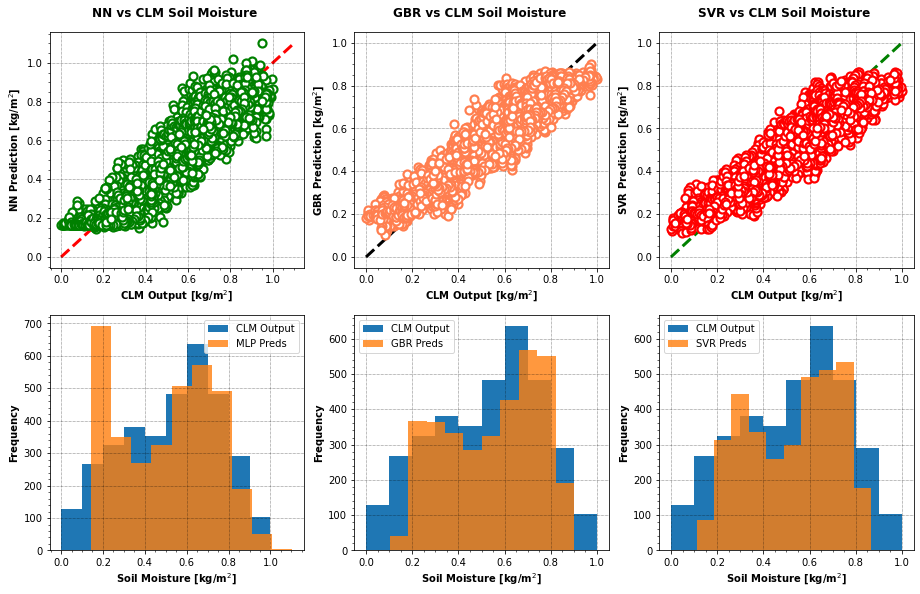

In [29]:
#=================================================================================
#     Model Prediction Comparison with CLM output
#=================================================================================

plt.figure(figsize=(15,9))

#=================================Scatter plot of the soil moisture reference SPMIP data and Simmulated data
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.2)
plt.subplot(2,3,1)
plt.plot(true_y, nnpredict_soilmoisture[:,0],'o',  c="green", \
         markerfacecolor = 'white', markersize = 8, markeredgewidth=2.2)
plt.ylabel('NN Prediction [kg/m$^{2}$]',fontweight='bold',fontsize=10)
plt.xlabel('CLM Output [kg/m$^{2}$]',fontweight='bold',fontsize=10)
plt.plot([0, 1.0917076], [0, 1.0917076], zorder=0.1, c='red',linestyle='dashed', linewidth=3)
plt.title("NN vs CLM Soil Moisture ", pad=15, fontweight='bold', fontsize=12)#[kg/m$^{2}$]
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')


plt.subplot(2,3,2)
plt.plot(true_y, gbr_predict_y,'o', color='coral', markerfacecolor = 'white', markersize = 8, 
                 markeredgewidth=2.2)
plt.ylabel('GBR Prediction [kg/m$^{2}$]',fontweight='bold',fontsize=10)
plt.xlabel('CLM Output [kg/m$^{2}$]',fontweight='bold',fontsize=10)
plt.plot([0, 1], [0, 1], zorder=0.1, c='black',linestyle='dashed', linewidth=3)
#sns.set_title("EOF"+str(j+1)+" GPP")
plt.title("GBR vs CLM Soil Moisture ", pad=15, fontweight='bold', fontsize=12)#[kg/m$^{2}$]
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')


plt.subplot(2,3,3)
plt.plot(true_y, svr_predict_y,'o',  c="red", \
         markerfacecolor = 'white', markersize = 8, markeredgewidth=2.2)
plt.ylabel('SVR Prediction [kg/m$^{2}$]',fontweight='bold',fontsize=10)
plt.xlabel('CLM Output [kg/m$^{2}$]',fontweight='bold',fontsize=10)
plt.plot([0, 1], [0, 1], zorder=0.1, c='green',linestyle='dashed', linewidth=3)
plt.title("SVR vs CLM Soil Moisture ", pad=15, fontweight='bold', fontsize=12) #[kg/m$^{2}$]
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

#=================================Histogram of the soil moisture reference SPMIP data and Simmulated data
plt.subplot(2,3,4)
plt.hist(true_y, bins=10, label="CLM Output")
plt.hist(nnpredict_soilmoisture[:,0], bins=10, alpha=0.8, label="MLP Preds")
plt.ylabel("Frequency",fontweight='bold',fontsize=10)
plt.xlabel('Soil Moisture [kg/m$^{2}$]',fontweight='bold',fontsize=10)#[kg/m$^{2}$]
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.legend()


plt.subplot(2,3,5)
plt.hist(true_y, bins=10, label="CLM Output")
plt.hist(gbr_predict_y, bins=10, alpha=0.8, label="GBR Preds")
plt.ylabel("Frequency",fontweight='bold',fontsize=10)
plt.xlabel('Soil Moisture [kg/m$^{2}$]',fontweight='bold',fontsize=10)#[kg/m$^{2}$]
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.legend()

plt.subplot(2,3,6)
plt.hist(true_y, bins=10, label="CLM Output")
plt.hist(svr_predict_y, bins=10, alpha=0.8, label="SVR Preds")
plt.minorticks_on()
plt.ylabel("Frequency",fontweight='bold',fontsize=10)
plt.xlabel('Soil Moisture [kg/m$^{2}$]',fontweight='bold',fontsize=10)#[kg/m$^{2}$]
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.legend()
plt.show()

<div class="alert alert-success">

### Comparing Performance of the Models with the Reference Data
The plots schows the prediction of soil moiture time series using unconstructed Y soil moisture

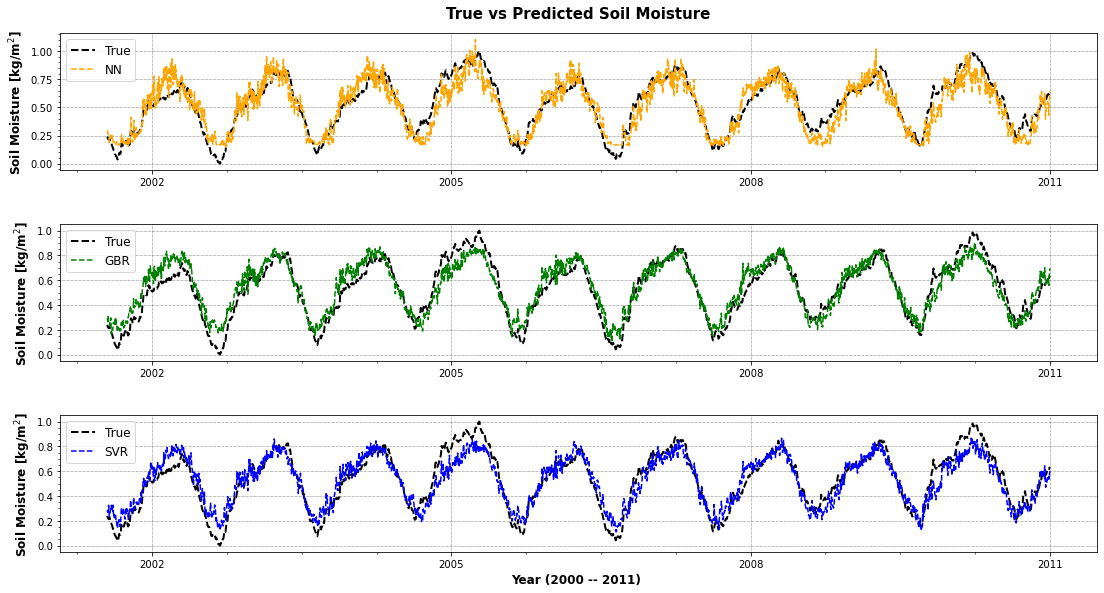

In [30]:
#=================================================================================
#     Comparing Performance of the Models with the Reference Data
#=================================================================================


plt.figure(figsize=(18,9))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
#=============================== Neural Network 
plt.subplot(3,1,1)
plt.plot(soil_moisture["time"][timesplit:],trueY_soilmoisture,label='True',\
         color = 'black',linestyle='dashed', linewidth = 2)
plt.plot(soil_moisture["time"][timesplit:],nnpredict_soilmoisture[:,0],label='NN',\
         color = 'orange',linestyle='dashed', linewidth = 1.5)
plt.ylabel(f"Soil Moisture [kg/m$^{2}$]",fontweight='bold', fontsize=12)
#plt.xlabel("Year (2000 -- 2011) ",fontweight='bold',fontsize=12)
plt.title("True vs Predicted Soil Moisture", pad=15, fontweight='bold', fontsize=15)
plt.minorticks_on()
plt.legend(loc="upper left", fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')


#=============================== Gradient Boosting Regressor  
plt.subplot(3,1,2)
plt.plot(soil_moisture["time"][timesplit:],true_y,label='True',color = 'black',\
         linestyle='dashed', linewidth = 2)
plt.plot(soil_moisture["time"][timesplit:],gbr_predict_y,label='GBR',\
         color = 'green',linestyle='dashed', linewidth = 1.5)
plt.ylabel(f"Soil Moisture [kg/m$^{2}$]",fontweight='bold', fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')

#=============================== Support Vector Regression
plt.subplot(3,1,3)
plt.plot(soil_moisture["time"][timesplit:],true_y,label='True',\
         color = 'black',linestyle='dashed', linewidth = 2)
plt.plot(soil_moisture["time"][timesplit:],svr_predict_y,label='SVR',\
         color = 'blue',linestyle='dashed', linewidth = 1.5)
plt.ylabel(f"Soil Moisture [kg/m$^{2}$]",fontweight='bold', fontsize=12)
plt.xlabel("Year (2000 -- 2011) ",fontweight='bold',fontsize=12)
plt.minorticks_on()
plt.legend(loc="upper left", fontsize=12)
plt.grid(linestyle=':', linewidth=0.5, color='k')

# #=============================== Support Vector Regression
# plt.subplot(4,1,4)
# plt.plot(soil_moisture["time"][timesplit:],true_y,label='True',color = 'black',linestyle='dashed', linewidth = 2)
# plt.plot(soil_moisture["time"][timesplit:],pred,label='SVR',color = 'blue',linestyle='dashed', linewidth = 1.5)
# plt.ylabel(f"Soil Moisture [kg/m$^{2}$]",fontweight='bold', fontsize=12)
# plt.xlabel("Year (2000 -- 2011) ",fontweight='bold',fontsize=12)
# plt.minorticks_on()
# plt.legend(loc="upper left", fontsize=12)
# plt.grid()
# plt.show()
# plt.show()

<div class="alert alert-success">